In [1]:
import pandas as pd

# Cargamos el dataset diabetes.csv
df = pd.read_excel('farmacias_con_clusters.xlsx')
df = df.dropna()  # Eliminamos filas con valores nulos

# Convertir con map
mapping = {'PROPIA': 0, 'FRANQUICIA': 1}
df['tipofarmacia'] = df['tipofarmacia'].map(mapping)

mapping = {'ECONOMICAS': 0, 'MEDICITY': 1}
df['sucursal'] = df['sucursal'].map(mapping)

In [2]:
# Seleccionamos las columnas predictoras
X = df.drop('perfil', axis=1)
X = X.drop('farmacia', axis=1)
X.head()

# Seleccionamos la columna diabetes como variable objetivo
y = df['perfil']
y.head()
X



,tipofarmacia,venta,trx,nomina,sucursal,cluster
0,1,63026.8760,6949,4,0,0
1,1,61003.9857,5700,4,0,0
2,1,47367.4135,6742,4,0,0
3,1,44576.4200,5601,3,0,0
4,1,42267.3465,5182,3,0,0
...,...,...,...,...,...,...
958,0,22000.0000,1129,3,1,11
959,0,17465.7848,736,3,1,81
960,0,27000.0000,4059,4,0,34
961,0,27110.4669,4071,3,0,63


In [3]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

y_encoded

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# División de datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)



In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(8, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')  # Softmax para clasificación multiclase
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Lenovo i5\Documents\MAESTRIA IA YACHAY TECH\FUNDAMETOS DE INTELIGENCIA ARTIFICIAL\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
import keras_tuner as kt
import tensorflow as tf
# Importamos los módulos necesarios para la creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Creamos una funcion para definir el modelo de la red neuronal con hiperparámetros
def build_model(hp):
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(
        units=hp.Int("units1", min_value=6, max_value=32, step=4),
        input_dim=6,
        activation="relu"
    ))
    
    # Capa oculta
    model.add(Dense(
        units=hp.Int("units2", min_value=4, max_value=16, step=2),
        activation="relu"
    ))
    
    # Capa de salida
    model.add(Dense(13, activation="softmax"))  #seleccionamos la función de activación softmax.
    
    # Compilación
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
        ),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# Configuramos el tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=4,             # número de combinaciones a probar
    executions_per_trial=3,    # repeticiones por combinación
    directory="tuner_dir",
    project_name="keras_model_tuning"
)

# Realizamos la busqueda de hiperparámetros
tuner.search(X_train, y_train, epochs=149, batch_size = 32, validation_split=0.2)

# Una vez finalizada la búsqueda imprimimos los mejores hiperparámetros:
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

Trial 4 Complete [00h 00m 59s]
val_accuracy: 0.17748917639255524

Best val_accuracy So Far: 0.2380952388048172
Total elapsed time: 00h 02m 10s
{'units1': 6, 'units2': 14, 'learning_rate': 0.001}


In [123]:
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), verbose=0)

In [148]:
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")

# Predicciones
predicciones = best_model.predict(X_test)
pred_clases = encoder.inverse_transform(predicciones)
print(pred_clases)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2158 - loss: 0.2394  
Accuracy: 0.22
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
[[47]
 [47]
 [46]
 [47]
 [52]
 [47]
 [46]
 [46]
 [43]
 [44]
 [47]
 [47]
 [48]
 [46]
 [46]
 [46]
 [46]
 [45]
 [44]
 [47]
 [52]
 [47]
 [52]
 [45]
 [48]
 [47]
 [47]
 [46]
 [49]
 [52]
 [46]
 [46]
 [44]
 [52]
 [46]
 [48]
 [47]
 [48]
 [47]
 [47]
 [45]
 [46]
 [52]
 [52]
 [46]
 [46]
 [52]
 [52]
 [46]
 [44]
 [47]
 [52]
 [47]
 [47]
 [46]
 [44]
 [47]
 [52]
 [52]
 [47]
 [47]
 [46]
 [47]
 [52]
 [52]
 [46]
 [46]
 [52]
 [52]
 [47]
 [52]
 [52]
 [45]
 [46]
 [52]
 [47]
 [46]
 [52]
 [52]
 [49]
 [52]
 [47]
 [47]
 [46]
 [44]
 [46]
 [46]
 [46]
 [46]
 [46]
 [46]
 [47]
 [47]
 [46]
 [49]
 [44]
 [46]
 [46]
 [52]
 [45]
 [46]
 [45]
 [52]
 [47]
 [52]
 [43]
 [52]
 [52]
 [52]
 [47]
 [44]
 [46]
 [48]
 [47]
 [46]
 [46]
 [46]
 [47]
 [46]
 [46]
 [46]
 [46]
 [47]
 [46]
 [52]
 [46]
 [46]
 [46]
 [46]
 [52]
 [52]
 [47]
 [52]
 [52]
 [46]
 [47]
 [47]
 [46]
 [46]
 [52]
 [46]
 [52]
 [43]
 [47]
 [52]
 [47

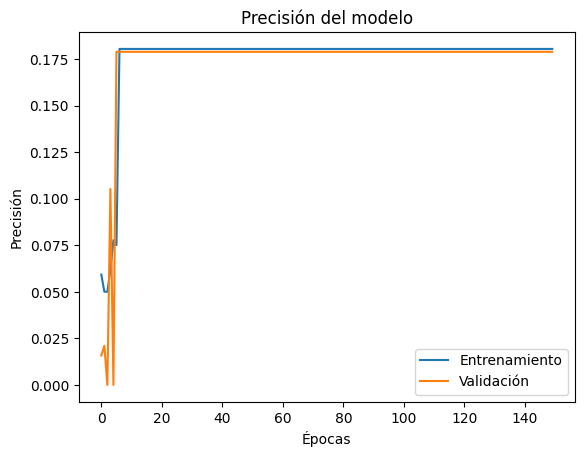

In [139]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [163]:
nuevo_caso = {
    'tipofarmacia': 0,  # 'PROPIA': 0, 'FRANQUICIA': 1
    'venta': 23109,  # Proporción de terrenos residenciales
    'trx': 4159,  # Proporción de acres comerciales
    'nomina': 2,  # Variable ficticia Charles River
    'sucursal': 0,  #{'ECONOMICAS': 0, 'MEDICITY': 1}
    'cluster': 11,  # Número medio de habitaciones por vivienda
    
}

In [164]:
import pandas as pd

# Convertir a DataFrame
nuevo_df = pd.DataFrame([nuevo_caso])

# Escalar con el mismo scaler usado en entrenamiento
nuevo_scaled = scaler.transform(nuevo_df)

In [161]:
# Predecir con el modelo entrenado
pred_softmax = best_model.predict(nuevo_scaled)

# Decodificar con el OneHotEncoder
pred_perfil = encoder.inverse_transform(pred_softmax)

print(f"Perfil predicho: {pred_perfil[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Perfil predicho: 46
